**Collaborative
 Filtering**

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn
import numpy as np
import pandas as pd

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import sys
# 코랩의 경우 나눔 폰트를 설치합니다.
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용합니다.
import matplotlib

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123632 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [4]:
from google.colab import files
uploaded = files.upload()

# 업로드한 파일 사용
data = pd.read_csv("netflix.csv")
data['genres'] = data['genres'].str.replace(',', '')  # 쉼표 제거

Saving netflix.csv to netflix.csv


In [5]:
# 데이터를 올바르게 불러왔는지 확인
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6828 entries, 0 to 6827
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               6828 non-null   object 
 1   type                6828 non-null   object 
 2   genres              6828 non-null   object 
 3   releaseYear         6828 non-null   int64  
 4   imdbId              6828 non-null   object 
 5   imdbAverageRating   6828 non-null   float64
 6   imdbNumVotes        6828 non-null   int64  
 7   availableCountries  6828 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 426.9+ KB
None


협업 필터링 모델
SVD사용

superise 라이브러리 설치

In [9]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 5.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357284 sha256=62e1331cd06c4e50d936de10bda0b2ca5eedd7a58d213a33fd4a3a3ff06e6326
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [10]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate

In [11]:
import surprise
print(surprise.__version__)

1.1.4


영화 데이터 준비

In [12]:
# 'title' -> 영화 제목, 'imdbAverageRating' -> 가상의 평점으로 사용
data_for_cf = data[['title', 'imdbAverageRating']].copy()
data_for_cf['user_id'] = [f"user_{i%10}" for i in range(len(data_for_cf))]  # 10명의 사용자 생성
data_for_cf.rename(columns={'title': 'item_id', 'imdbAverageRating': 'rating'}, inplace=True)

In [13]:
# Surprise 라이브러리를 위한 데이터셋 형식 변환
reader = Reader(rating_scale=(0, 10))  # IMDb 평점 범위
dataset = Dataset.load_from_df(data_for_cf[['user_id', 'item_id', 'rating']], reader)


In [14]:
# SVD 모델 생성 및 평가
svd = SVD()
cross_validate(svd, dataset, cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0467  1.0115  1.0633  1.0385  1.0786  1.0477  0.0228  
MAE (testset)     0.8175  0.7962  0.8312  0.8058  0.8464  0.8194  0.0178  
Fit time          0.07    0.08    0.07    0.08    0.07    0.07    0.00    
Test time         0.00    0.00    0.00    0.01    0.00    0.00    0.00    


{'test_rmse': array([1.04667094, 1.0114959 , 1.06325962, 1.03847057, 1.07860842]),
 'test_mae': array([0.81751877, 0.79623279, 0.83115698, 0.80583148, 0.8463594 ]),
 'fit_time': (0.07291364669799805,
  0.07505178451538086,
  0.07208132743835449,
  0.0751953125,
  0.07348036766052246),
 'test_time': (0.00494384765625,
  0.004319190979003906,
  0.004667758941650391,
  0.005171537399291992,
  0.004527091979980469)}

est_rmse (Root Mean Squared Error):

예측 값과 실제 평점 간의 차이의 제곱 평균의 제곱근입니다.
값이 작을수록 모델의 예측이 더 정확하다는 것을 의미합니다.
예: RMSE = 0.85라면 평균적으로 약 0.85점 차이가 난다는 뜻입니다.

test_mae (Mean Absolute Error):

예측 값과 실제 값 간의 차이의 절대값 평균입니다.
값이 작을수록 더 나은 모델입니다.
예: MAE = 0.70이라면 평균적으로 0.70점의 오차가 있다는 뜻입니다.

1.1 RMSE (Root Mean Squared Error)
Fold별 RMSE:
Fold 1: 1.0467
Fold 2: 1.0115
Fold 3: 1.0633
Fold 4: 1.0385
Fold 5: 1.0786
Mean (평균 RMSE): 1.0477
Std (표준 편차): 0.0228
해석:

RMSE는 예측 평점과 실제 평점 간의 평균적인 오차를 나타냅니다.
평균 RMSE가 1.0477이라는 것은, 모델의 평점 예측이 약 1.05점 정도의 오차를 가지고 있음을 의미합니다.
표준 편차(0.0228)가 작기 때문에, 5개의 Fold 결과가 비교적 안정적이라고 볼 수 있습니다.

1.2 MAE (Mean Absolute Error)
Fold별 MAE:
Fold 1: 0.8175
Fold 2: 0.7962
Fold 3: 0.8312
Fold 4: 0.8058
Fold 5: 0.8464
Mean (평균 MAE): 0.8194
Std (표준 편차): 0.0178
해석:

MAE는 예측과 실제 평점 간의 절대적인 차이를 나타냅니다.
평균 MAE가 0.8194라는 것은, 모델의 예측이 약 0.82점 정도의 오차를 가지고 있음을 나타냅니다.



In [15]:
# 모델 학습
trainset = dataset.build_full_trainset()
svd.fit(trainset)

In [16]:
# 영화 추천 함수
def recommend_movies_cf(user_id, top_n=5):
    # 모든 영화에 대해 예측 점수 계산
    movies = data['title'].unique()
    predictions = [svd.predict(user_id, movie) for movie in movies]

    # 예측 점수 기준으로 정렬하여 상위 top_n 추천
    predictions = sorted(predictions, key=lambda x: x.est, reverse=True)
    top_movies = predictions[:top_n]

    # 추천 영화 반환
    recommended_movies = [pred.iid for pred in top_movies]
    return data[data['title'].isin(recommended_movies)]

# 예시 사용자에 대한 영화 추천
recommended_cf = recommend_movies_cf('user_0')
print("협업 필터링 추천 영화 목록:")
print(recommended_cf)

협업 필터링 추천 영화 목록:
                 title type                      genres  releaseYear  \
4440           Gintama   tv     Action Animation Comedy         2005   
4500           Misaeng   tv                       Drama         2014   
4640          Doraemon   tv      Animation Comedy Drama         2005   
5000  When They See Us   tv       Biography Crime Drama         2019   
5210      Vinland Saga   tv  Action Adventure Animation         2019   

          imdbId  imdbAverageRating  imdbNumVotes  \
4440   tt0988818                8.7         16721   
4500   tt4240730                8.5          2798   
4640   tt4083422                8.4          4371   
5000   tt7137906                8.8        143637   
5210  tt10233448                8.8         86192   

                                     availableCountries  
4440                                             JP, KR  
4500  AD, AG, AL, AO, AR, AT, AU, AZ, BA, BB, BG, BM...  
4640                                             JP, KR  

비교

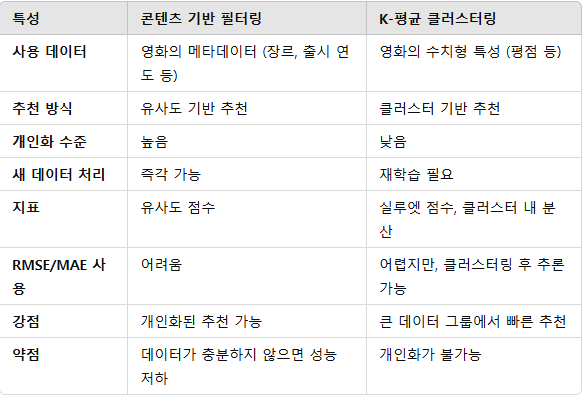

개인화된 추천이 중요하다면 콘텐츠 기반 필터링이 적합합니다.
속도와 확장성이 중요한 대규모 데이터셋에서는 K-평균이 유리할 수 있습니다.

개인화 된 추천이 필요하기 때문에 Content based Filtering 이 적합합니다.